# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance
from ipywidgets import interact, IntSlider, fixed, FloatSlider


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [7]:
USER_NAME = u"Горбушин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.
$$ Обозначения: x^{(i)} \, это \, i-ый \, объкет \\ x_j^{(i)}\, это\, j-ый \, признак \, i-ого \, объекта \\ \frac{\partial L}{\partial \omega_j} = -\frac {1}{N} \sum_{i=1}^{N} \frac {e^{-y^{(i)} g(x^{(i)})}}{1 + e^{-y^{(i)} g(x^{(i)})}} x_j^{(i)} y^{(i)}  \\ \omega_j^{k + \frac{1}{2}}  = \omega_j^{k} + \alpha_k \frac{\partial L}{\partial \omega_j}\\ if \, (\omega_j^{k + \frac{1}{2}} > 0) \, then \\  \omega_j^{k + \frac{1}{2}} = \textit{max}(0, \omega_j^{k + \frac{1}{2}} - \alpha_k \frac {C}{N}) \\  else \\ \omega_j^{k + \frac{1}{2}} = \textit{max}(0, \omega_j^{k + \frac{1}{2}} + \alpha_k \frac {C}{N}) 
$$


## Имплементация (5 баллов)

In [163]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, show_process=False, batch_size=-1):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.show_process = show_process
        self.batch_size = batch_size
    
    def _sigmoid(self, v):
        return 1 / (1 + np.exp(-v))
        
    def _margin(self, x_i, y_i):
        return y_i * (self.weights[0] + (self.weights[1:] * x_i).sum())
    
    def _sum_numerator(self, x_i, y_i):
        return np.exp(-self._margin(x_i, y_i))
    
    def _sum_divider(self, x_i, y_i):
        return (1 + np.exp(-self._margin(x_i, y_i)))
    
    def _sum_frac(self, x_i, y_i, w_j):
        # for w0 no x0, only for w_i, i >= 1
        j_feature_value = 1
        if w_j:
            j_feature_value = x_i[w_j - 1]
        else:
            j_feature_value = 1
            
        return -y_i * j_feature_value * self._sum_numerator(x_i, y_i) / self._sum_divider(x_i, y_i)
    
    def say_error(self, X, y):
        return np.array(
            [np.log(1 + np.exp(-self._margin(X[i], y[i]) ) ) for i in range(X.shape[0])]
        ).sum() / len(X)
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.weights = np.ones(X.shape[1] + 1, np.float32)
        grad = np.zeros(X.shape[1] + 1, np.float32)
                
        cur_epoch = 0
        N = X.shape[0]
        features_n = X.shape[1] + 1
        alpha = self.alpha
        self.error_log = []
        y[y == 0] = -1
        
        batch_size = N
        if (self.batch_size != -1):
            batch_size = self.batch_size
            
        
        while (cur_epoch < self.max_epoch):
            
            if (self.show_process):
                print cur_epoch
            self.error_log.append(self.say_error(X, y))
            
            # берем случайный порядок
            random_order = np.arange(features_n)
            np.random.shuffle(random_order)
            
            random_obj_index = np.arange(N)
            np.random.shuffle(random_obj_index)
            
            grad = np.array([
                np.array(
                    [self._sum_frac(X[obj_index], y[obj_index], w_j) 
                     for obj_index in random_obj_index[:batch_size] 
                    ]).sum() / float(batch_size) 
                for w_j in random_order
            ])
            
            grad *= alpha            
            for i in xrange(len(grad)):
                if (grad[i] > 0):
                    grad[i] = max(0, grad[i] - alpha * self.C / float(N))
                else:
                    grad[i] = min(0, grad[i] + alpha * self.C / float(N))
            
            self.weights -= grad[random_order.argsort()]
            cur_epoch += 1
            alpha = self.alpha / float(cur_epoch)
            
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
    
    def get_weights(self):
        return self.weights
    
    def get_error_log(self):
        return self.error_log
    
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        v = np.array([ self.weights[0] + (self.weights[1:] * x).sum() for x in X])
        v[v > 0] = 1
        v[v <= 0] = 0
        return v
        
    def predict_by_probe(self, X, threshold):
        prob = self.predict_proba(X)
        prob[prob > threshold] = 1
        prob[prob < threshold] = 0
        return prob
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        g_x = np.array([(self.weights[0] + (self.weights[1:] * x).sum()) for x in X])
        return np.array([self._sigmoid(g_x_i) for g_x_i in g_x])

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

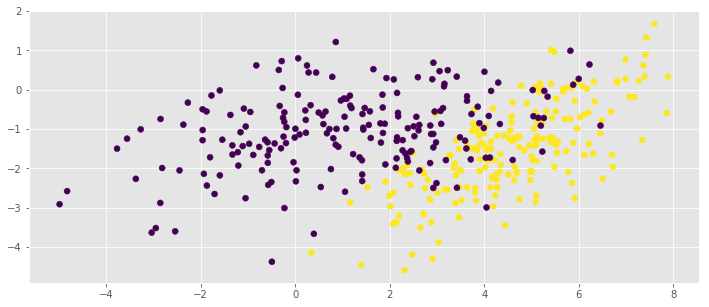

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [7]:
w = np.array([0,0,0])
def demo(C, alpha):
    clf = MySGDClassifier(max_epoch=50, C=C, alpha=alpha)
    clf.fit(X, y)
    my_y = clf.predict(X)
    w = clf.get_weights()
    my_y = my_y.astype('int')
    print np.bincount(my_y)
    print np.bincount(my_y[200:])
    print np.bincount(my_y[:200])
    print clf.predict_proba(X)
    print w
    return w
w = demo(1, 10)

[183 217]
[166  34]
[ 17 183]
[ 0.4575  0.5425]
[-4.6923151   1.17103219 -0.75079137]


[-4.6923151   1.17103219 -0.75079137]


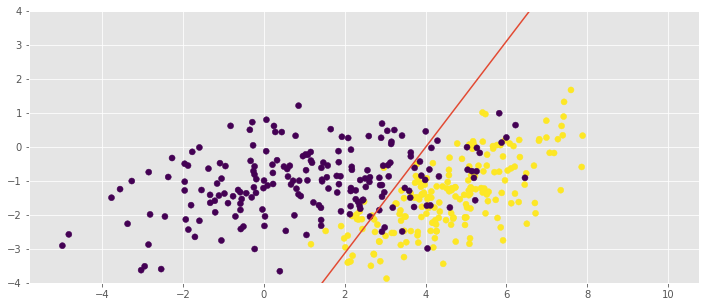

In [8]:
import matplotlib.lines as mlines
import matplotlib.pyplot

print w
x1 = np.linspace(-5,10)
y1 = (-w[0] - w[1] * x1) / w[2]
matplotlib.pyplot.ylim( (-4, 4) )
plt.plot(x1, y1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()


## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [153]:
from sklearn.datasets import make_classification
import matplotlib.patches as mpatches
n_features = 10

In [88]:
X, y = make_classification(n_samples=10000, n_features=n_features, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)


Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [158]:
## Your Code Here
alpha_n = 10
epoch_n = 10
alpha_r = np.arange(1, alpha_n + 1, 1)
error_r = np.empty((alpha_n, epoch_n))
index = 0
for alpha in alpha_r:
    
    clf = MySGDClassifier(C = 1, alpha = alpha, max_epoch=epoch_n)
    clf.fit(X, y)
    
    error_r[index] = clf.get_error_log()
    
    index += 1

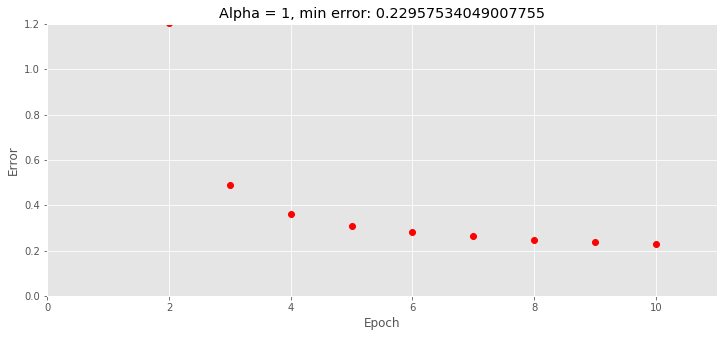

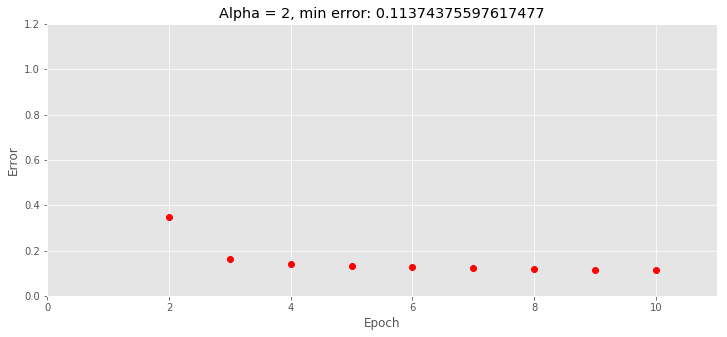

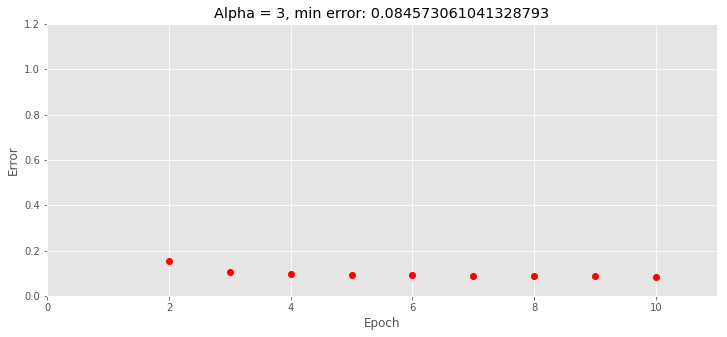

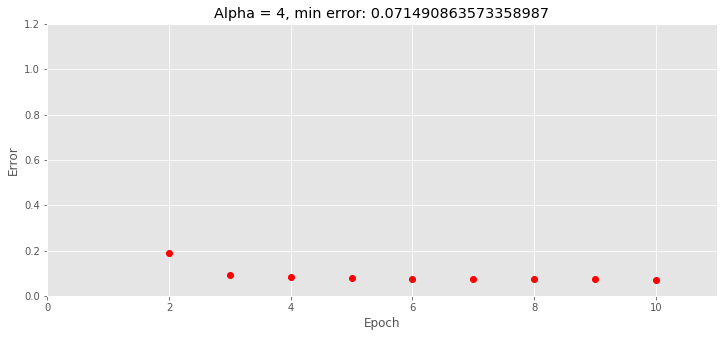

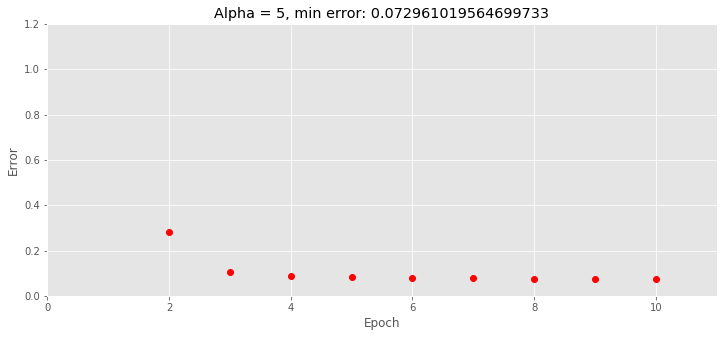

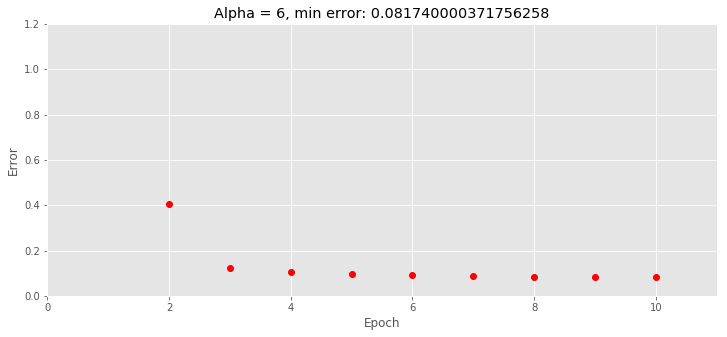

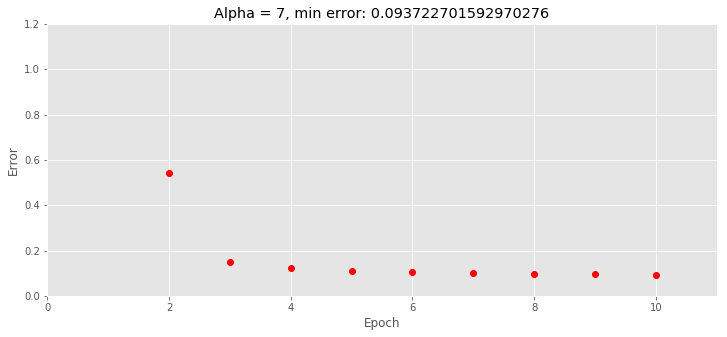

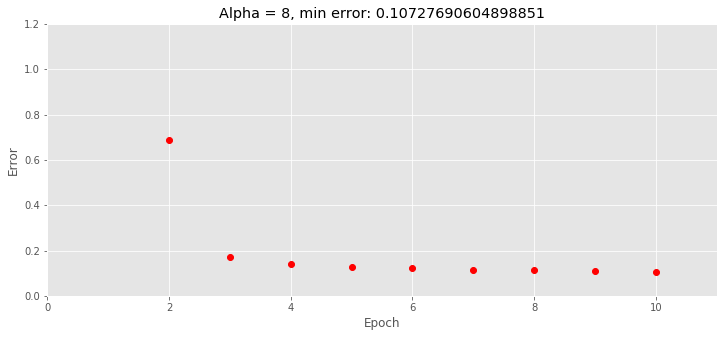

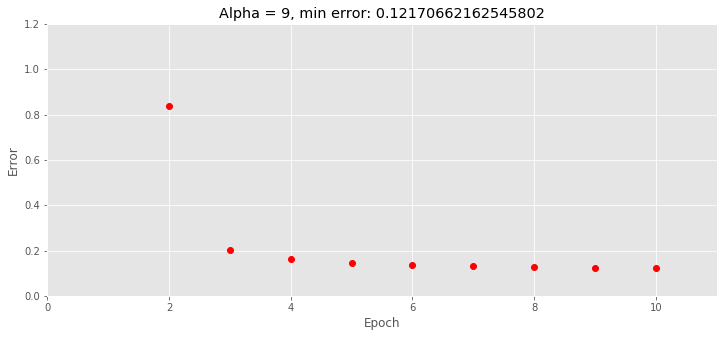

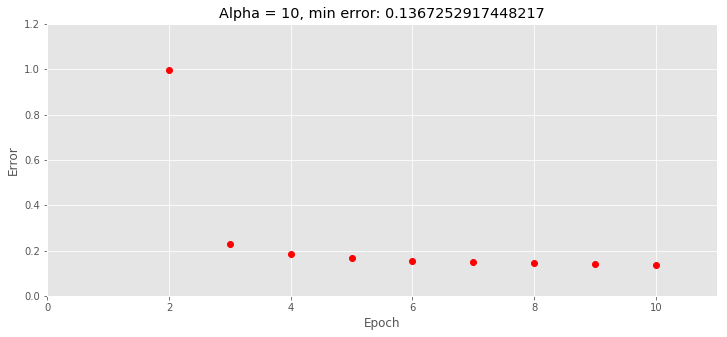

In [159]:
error_r
alpha = 1
for error in error_r:
    
    plt.title("Alpha = " + `alpha` + ", min error: " + `error.min()`)
    plt.xlabel('Epoch')
    plt.ylabel("Error")
    
    plt.plot(np.arange(1, alpha_n + 1), error, 'ro')
    plt.axis([0, epoch_n + 1, 0, 1.2])
    
    plt.show()
    alpha += 1

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

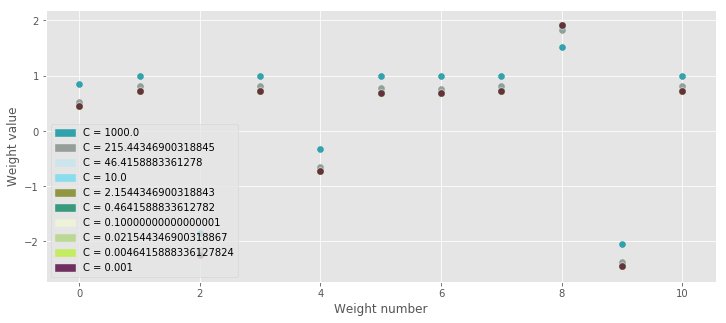

In [163]:
# по графикам видим, что самое хорошее alpha = 4
c_n = 10
c_range = np.logspace(3, -3, c_n)
w_res = np.empty((len(c_range), n_features + 1))
index = 0
pathes = []

for c in c_range:
    
    clf = MySGDClassifier(C = c, alpha = 4, max_epoch=1)
    clf.fit(X, y)
    
    w_res[index] = clf.get_weights()
    
    color = np.array([np.random.rand(), np.random.rand(), np.random.rand(),0.8])
    plt.scatter(np.arange(n_features + 1), clf.get_weights(), c=color)
    
    patch = mpatches.Patch(color=color, label='C = ' + `c`)
    pathes.append(patch)
    
    index += 1
    
plt.xlabel("Weight number")
plt.ylabel("Weight value")
plt.legend(handles=pathes)
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [147]:
# вернуть Х и у для сета
def getX(filename):
    df_data = pd.read_csv(filename, sep=',')
    y = df_data['decision']
    X = df_data.drop(['gamestate_id', 'decision'], 1)
    X[X.columns] = (X[X.columns] - X[X.columns].mean()) / X[X.columns].std()
    return X.values, y.values

In [165]:
# обучаемся
from sklearn.metrics import mean_squared_error

bad = 0
cls = MySGDClassifier(C=100, alpha=3, max_epoch=40, batch_size=5000, show_process=True)
cls.fit(X, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


MySGDClassifier(C=100, alpha=3, batch_size=5000, max_epoch=40,
        show_process=True)

In [153]:
# смотрим лог ошибок
cls.get_error_log()

[4.6413095541983562,
 2.0153430601085054,
 1.3947095727665659,
 1.2209616086651134,
 1.1097741929729863,
 1.0306271441022672,
 0.97628015013838432,
 0.93516356017017244,
 0.90278441836095802,
 0.87579145955204685,
 0.85325276192107036,
 0.83380418186785388,
 0.81782775151991449,
 0.80459224784248529,
 0.79249765282541684,
 0.78161989991861325,
 0.77207402531138525,
 0.76376512225104976,
 0.75601760048185895,
 0.74897137361658683,
 0.7428303496681804,
 0.73707914544525566,
 0.73123959571733799,
 0.7265597445561004,
 0.72196622372878105,
 0.71765402815479917,
 0.71370835121643406,
 0.71004423585994969,
 0.70655653761545789,
 0.70334699994643934,
 0.70026760206584993,
 0.69754774289398269,
 0.69496974901016662,
 0.69218077607231643,
 0.68971195747726499,
 0.6875361653623715,
 0.68535682820240351,
 0.68318462152727144,
 0.681345510423225,
 0.67956599092985071]

In [160]:
from sklearn.metrics import roc_auc_score

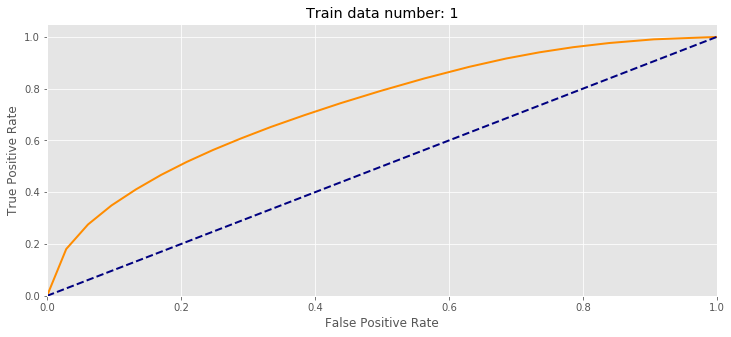

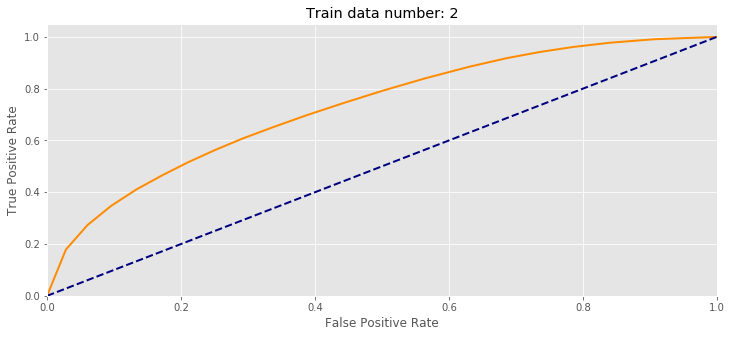

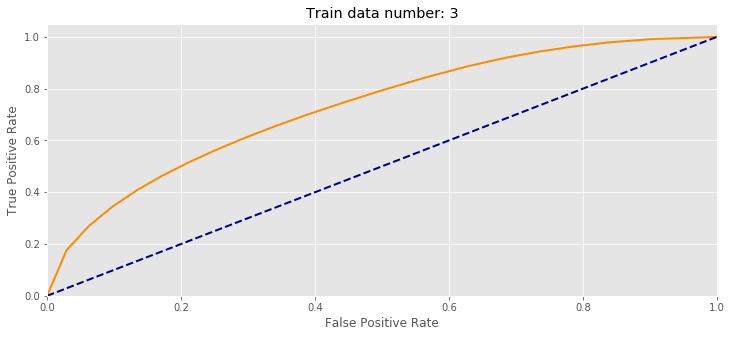

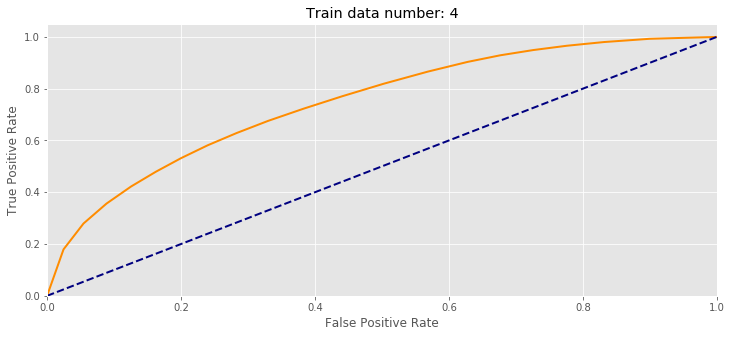

In [186]:
# строим roc кривые для 4 сетов других
for d in range(1, 5):
    X, y = getX("./train1/trainingData_tabular_chunk%d.csv" % d)


    thresholds = np.arange(0, 1, 0.05)
    tpr = []
    fpr = []
    for threshold in thresholds:
        my_y = cls.predict_by_probe(X, threshold)

        tn, tp, fp, fn = float(0), float(0), float(0), float(0)
        for i in range(len(y)):
            if (y[i] == 1 and my_y[i] == 1):
                tp += 1
            if (y[i] == 1 and my_y[i] == 0):
                fn += 1
            if (y[i] == 0 and my_y[i] == 1):
                fp += 1
            if (y[i] == 0 and my_y[i] == 0):
                tn += 1
        
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    tpr.append(0)
    fpr.append(0)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Train data number: %d" % d)
    plt.show()

In [100]:
import json
print y.shape
print y.values
X[:-1].to_csv("./train_data.csv", index=False)
y.to_csv("./train_ans.csv", index=False)

(500000,)
[1 1 1 ..., 1 0 0]


In [99]:
import os
import sys
np.empty((1, 1), 'float')
xs = np.array([1,2,3])
xs = xs.astype('float128')

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [102]:
a = range()
for i in range(4):
    print i
    if (i == 2):
        i -= 1

0
1
2
3


In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [ ]:
## Youd Code Here

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [ ]:
## Youd Code Here